## Your Code


In [14]:
import kuramoto
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse import linalg

In [15]:
# global variables
# This will change the initial condition used. Currently it starts from the first# value
shift_k = 0

approx_res_size = 3000


model_params = {"tau": 0.25, "nstep": 100, "N": 32, "d": 22}

# Parameters for the reservoir
res_params = {
    "radius": 0.1,                    # Radius of the reservoir
    "degree": 3,                      # Degree of the reservoir
    "sigma": 0.5,                     # Spread parameter
    "train_length": 28000,            # Length of training data
    "N": int(np.floor(approx_res_size / model_params["N"]) * model_params["N"]),  # Adjusted size of reservoir
    "num_inputs": model_params["N"],  # Number of inputs to the reservoir
    "predict_length": 2000,           # Length of prediction data
    "beta": 0.0001                    # Regularization parameter
}

In [16]:
# Define Echo State Network (ESN) functions
def generate_reservoir(size, radius, degree):
    """Generates the reservoir matrix A."""
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    vals = np.linalg.eigvals(A)
    e = np.max(np.abs(vals))
    A = (A / e) * radius
    return A


def reservoir_layer(A, Win, input, res_params):
    """Computes the state of the reservoir for given inputs."""
    states = np.zeros((res_params["N"], res_params["train_length"]))
    for i in range(res_params["train_length"] - 1):
        states[:, i + 1] = np.tanh(np.dot(A, states[:, i]) + np.dot(Win, input[:, i]))
    return states


def train_reservoir(res_params, data):
    """Trains using the trained reservoir."""
    A = generate_reservoir(res_params["N"], res_params["radius"], res_params["degree"])
    q = int(res_params["N"] / res_params["num_inputs"])
    Win = np.zeros((res_params["N"], res_params["num_inputs"]))
    for i in range(res_params["num_inputs"]):
        np.random.seed(seed=i)
        Win[i * q : (i + 1) * q, i] = res_params["sigma"] * (
            -1 + 2 * np.random.rand(1, q)[0]
        )

    states = reservoir_layer(A, Win, data, res_params)
    Wout = train(res_params, states, data)
    x = states[:, -1]
    return x, Wout, A, Win


def train(res_params, states, data):
    """Sets up and trains an ESN using input data."""
    beta = res_params["beta"]
    idenmat = beta * sparse.identity(res_params["N"])
    states2 = states.copy()
    for j in range(2, np.shape(states2)[0] - 2):
        if np.mod(j, 2) == 0:
            states2[j, :] = (states[j - 1, :] * states[j - 2, :]).copy()
    U = np.dot(states2, states2.transpose()) + idenmat
    Uinv = np.linalg.inv(U)
    Wout = np.dot(Uinv, np.dot(states2, data.transpose()))
    return Wout.transpose()


def predict(A, Win, res_params, x, Wout):
    """Predicts future states using the trained reservoir."""
    output = np.zeros((res_params["num_inputs"], res_params["predict_length"]))
    # print(x.shape)

    for i in range(res_params["predict_length"]):
        x_aug = x.copy()
        # print("x_aug")
        # print(x_aug.shape)
        for j in range(2, np.shape(x_aug)[0] - 2):
            if np.mod(j, 2) == 0:
                x_aug[j] = (x[j - 1] * x[j - 2]).copy()
        # print(np.asarray(np.dot(Wout,x_aug).shape))
        out = np.squeeze(np.asarray(np.dot(Wout, x_aug)))
        output[:, i] = out
        x1 = np.tanh(np.dot(A, x) + np.dot(Win, out))
        x = np.squeeze(np.asarray(x1))
    return output, x

In [17]:
n_init = 1000  # remove the initial points
L = 22.0  # length
spatial_points = 32  # space discretization step
dt = 0.25  # time discretization step
tend = (res_params["train_length"] + res_params["predict_length"] + n_init) * dt
dns = kuramoto.KS(L=L / (2 * np.pi), N=spatial_points, dt=dt, tend=tend)
dns.simulate()
ks_data = dns.uu[n_init:].T

In [18]:
# Train reservoir
x, Wout, A, Win = train_reservoir(
    res_params, ks_data[:, shift_k : shift_k + res_params["train_length"]]
)

In [19]:
# Prediction
prediction, _ = predict(A, Win, res_params, x, Wout)
# (2976,)
# [ 1 32]

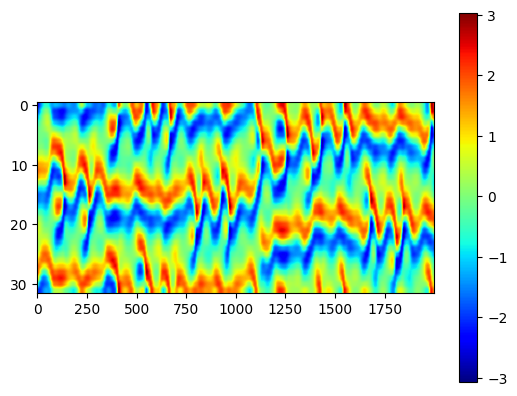

In [20]:
plt.imshow(
    ks_data[:, -res_params["predict_length"] :], cmap=plt.get_cmap("jet"), aspect=30
)
plt.colorbar()

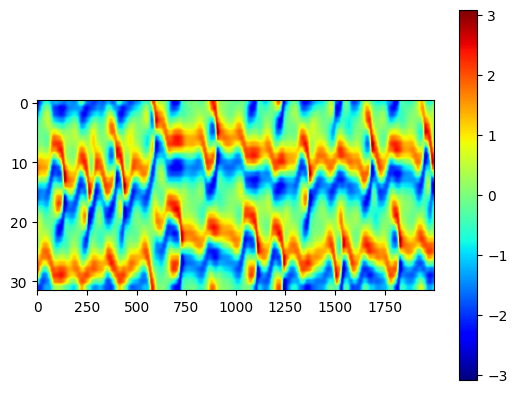

In [21]:
plt.imshow(prediction, cmap=plt.get_cmap("jet"), aspect=30)
plt.colorbar()

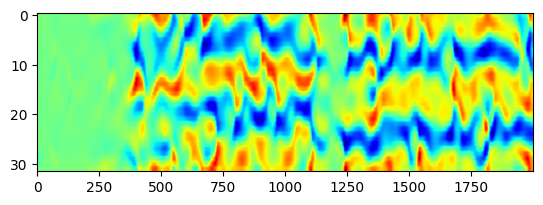

In [22]:
plt.imshow(
    ks_data[:, -res_params["predict_length"] :] - prediction,
    cmap=plt.get_cmap("jet"),
    aspect=20,
)

## GridSearch (FIRST TASK)

Completed for beta=1e-05, radius=0.05, sigma=0.3 | MSE=2.2555
Completed for beta=1e-05, radius=0.05, sigma=0.5 | MSE=2.5648
Completed for beta=1e-05, radius=0.05, sigma=0.7 | MSE=2.3013
Completed for beta=1e-05, radius=0.1, sigma=0.3 | MSE=1.7031
Completed for beta=1e-05, radius=0.1, sigma=0.5 | MSE=2.0863
Completed for beta=1e-05, radius=0.1, sigma=0.7 | MSE=2.3027
Completed for beta=1e-05, radius=0.15, sigma=0.3 | MSE=2.0869
Completed for beta=1e-05, radius=0.15, sigma=0.5 | MSE=2.0522
Completed for beta=1e-05, radius=0.15, sigma=0.7 | MSE=2.0108
Completed for beta=0.0001, radius=0.05, sigma=0.3 | MSE=2.3329
Completed for beta=0.0001, radius=0.05, sigma=0.5 | MSE=2.2762
Completed for beta=0.0001, radius=0.05, sigma=0.7 | MSE=2.2485
Completed for beta=0.0001, radius=0.1, sigma=0.3 | MSE=2.4308
Completed for beta=0.0001, radius=0.1, sigma=0.5 | MSE=2.2263
Completed for beta=0.0001, radius=0.1, sigma=0.7 | MSE=2.4123
Completed for beta=0.0001, radius=0.15, sigma=0.3 | MSE=2.2978
Complet

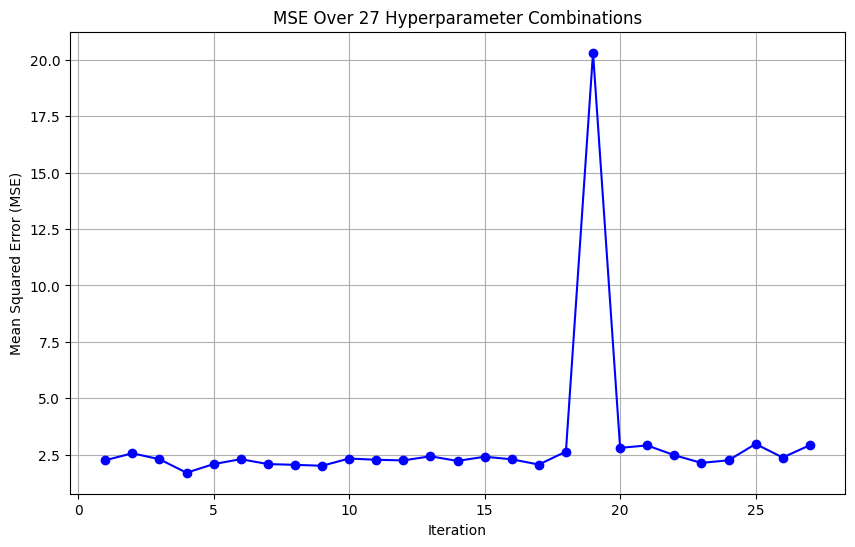

In [23]:
import itertools
import matplotlib.pyplot as plt

# Define the search grid for hyperparameters
beta_values = [0.00001, 0.0001, 0.001]
radius_values = [0.05, 0.1, 0.15]
sigma_values = [0.3, 0.5, 0.7]

# Create a grid of hyperparameter combinations
param_grid = list(itertools.product(beta_values, radius_values, sigma_values))


results = []


for beta, radius, sigma in param_grid:
    res_params['beta'] = beta
    res_params['radius'] = radius
    res_params['sigma'] = sigma
    
    # Train the reservoir
    x, Wout, A, Win = train_reservoir(
        res_params, ks_data[:, shift_k:shift_k + res_params["train_length"]]
    )
    
    # Make predictions
    prediction, _ = predict(A, Win, res_params, x, Wout)
    
    # Calculate the prediction error (Mean Squared Error)
    actual_data = ks_data[:, shift_k + res_params["train_length"]:shift_k + res_params["train_length"] + res_params["predict_length"]]
    mse = np.mean((prediction - actual_data) ** 2)
    
    # Store the results
    results.append((beta, radius, sigma, mse))
    print(f"Completed for beta={beta}, radius={radius}, sigma={sigma} | MSE={mse:.4f}")

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Beta', 'Radius', 'Sigma', 'MSE'])

# Find the best hyperparameters
best_params = results_df.loc[results_df['MSE'].idxmin()]

print("\nBest Hyperparameters:")
print(f"Beta: {best_params['Beta']}, Radius: {best_params['Radius']}, Sigma: {best_params['Sigma']} | MSE: {best_params['MSE']}")

#Ploting
# Extract the MSE values from the results
_, _, _, mse_values = zip(*results)

#It's not the right one, sorry (I don't want to run all this again because of plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Over 27 Hyperparameter Combinations')
plt.grid(True)
plt.show()

## Adding Gaussian Noice (SECOND TASK)

In [70]:
ks_data

array([[-0.36439274, -0.35592581, -0.31660715, ...,  2.44693089,
         2.37789687,  2.30860536],
       [ 0.19580579,  0.2058375 ,  0.20788731, ...,  2.5740543 ,
         2.54431917,  2.52037446],
       [ 0.58144211,  0.57684295,  0.58294784, ...,  1.61930096,
         1.70903139,  1.74419812],
       ...,
       [-1.84875688, -1.82546079, -1.83599425, ...,  0.4586741 ,
         0.416118  ,  0.403037  ],
       [-1.67321308, -1.65523698, -1.64925555, ...,  0.99604397,
         0.94142346,  0.89561935],
       [-1.05960123, -1.05576867, -1.01343157, ...,  1.72251451,
         1.67765226,  1.6057063 ]])

In [71]:
#I will do two times with (mu = 0.1 sigma = 0.1) and (mu = 0.01, 0.05)
gaussian_noice = np.random.normal(0.1, 0.1, size=(32,30001))
noicy_data = ks_data + gaussian_noice
noicy_data

array([[-0.40536169, -0.12135961, -0.07006281, ...,  2.40457138,
         2.46871707,  2.33653661],
       [ 0.36994488,  0.36360669,  0.2278837 , ...,  2.70055041,
         2.70788355,  2.50792802],
       [ 0.71397412,  0.74344114,  0.7804758 , ...,  1.48210023,
         1.75478547,  2.00059131],
       ...,
       [-1.81143311, -1.819944  , -1.58329455, ...,  0.70489805,
         0.62473431,  0.68965319],
       [-1.61286659, -1.52587948, -1.68261527, ...,  1.04369791,
         1.09930037,  0.85657649],
       [-0.90914788, -0.88614181, -0.89511188, ...,  1.78593942,
         1.69251201,  1.71035007]])

In [72]:
# Train reservoir
x, Wout, A, Win = train_reservoir(
    res_params, noicy_data[:, shift_k : shift_k + res_params["train_length"]]
)

In [73]:
noicy_pred, _ = predict(A, Win, res_params, x, Wout)

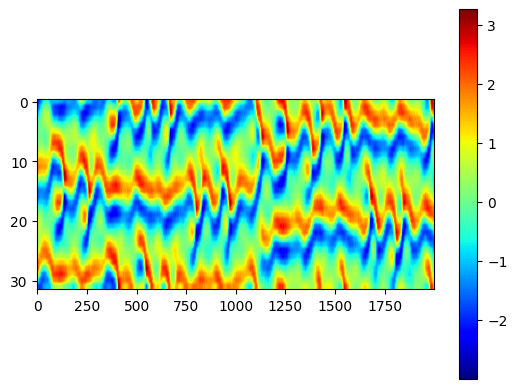

In [74]:
plt.imshow(
    noicy_data[:, -res_params["predict_length"] :], cmap=plt.get_cmap("jet"), aspect=30
)
plt.colorbar()

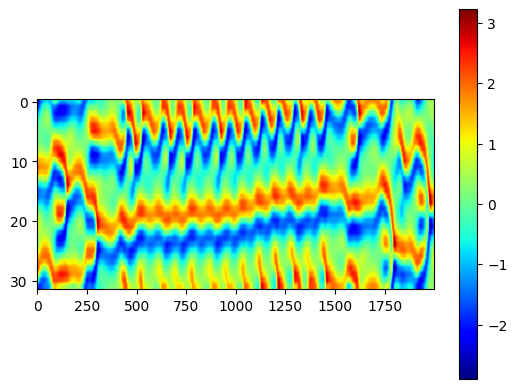

In [75]:
plt.imshow(noicy_pred, cmap=plt.get_cmap("jet"), aspect=30)
plt.colorbar()

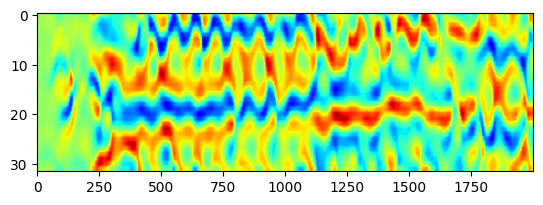

In [76]:
plt.imshow(
    noicy_data[:, -res_params["predict_length"] :] - noicy_pred,
    cmap=plt.get_cmap("jet"),
    aspect=20,
)

In [77]:
differ_1 = ks_data[:, -res_params["predict_length"] :] - prediction
differ_2 = noicy_data[:, -res_params["predict_length"] :] - noicy_pred

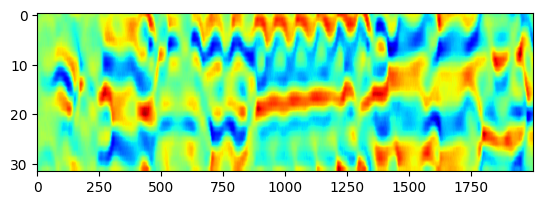

In [78]:
#Difference between noicy data and real data
plt.imshow(
    differ_1 - differ_2,
    cmap=plt.get_cmap("jet"),
    aspect=20,
)

In [79]:
gaussian_noice = np.random.normal(0.01, 0.05, size=(32,30001))
noicy_data_2 = ks_data + gaussian_noice
noicy_data_2

array([[-0.42487722, -0.27864271, -0.23333498, ...,  2.38575114,
         2.38330697,  2.28257099],
       [ 0.24287533,  0.24472209,  0.1778855 , ...,  2.59730236,
         2.58610136,  2.47415124],
       [ 0.60770812,  0.62014205,  0.64171182, ...,  1.51070059,
         1.69190843,  1.83239471],
       ...,
       [-1.870095  , -1.86270239, -1.7496444 , ...,  0.54178608,
         0.48042616,  0.5063451 ],
       [-1.68303984, -1.63055823, -1.70593541, ...,  0.97987094,
         0.98036191,  0.83609792],
       [-1.02437456, -1.01095524, -0.99427173, ...,  1.71422697,
         1.64508214,  1.61802818]])

In [80]:
# Train reservoir
x, Wout, A, Win = train_reservoir(
    res_params, noicy_data_2[:, shift_k : shift_k + res_params["train_length"]]
)

In [81]:
noicy_pred_2, _ = predict(A, Win, res_params, x, Wout)

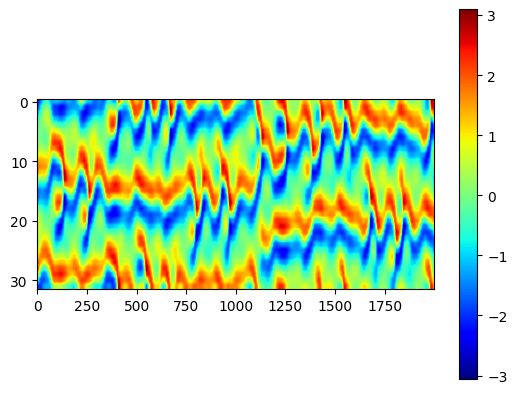

In [82]:
plt.imshow(
    noicy_data_2[:, -res_params["predict_length"] :], cmap=plt.get_cmap("jet"), aspect=30
)
plt.colorbar()

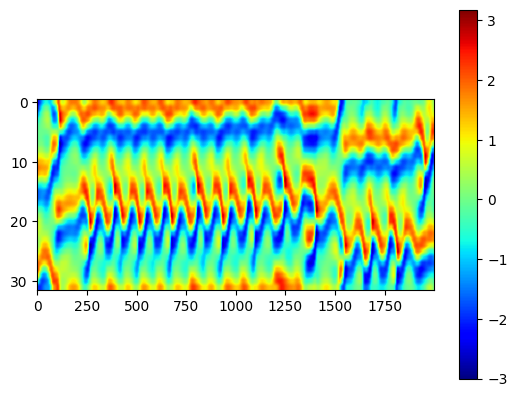

In [83]:
plt.imshow(noicy_pred_2, cmap=plt.get_cmap("jet"), aspect=30)
plt.colorbar()

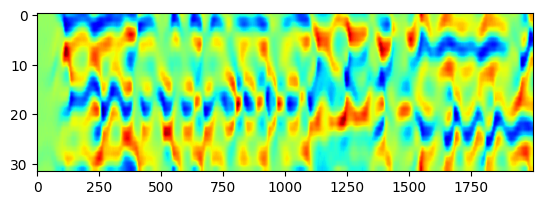

In [84]:
plt.imshow(
    noicy_data_2[:, -res_params["predict_length"] :] - noicy_pred_2,
    cmap=plt.get_cmap("jet"),
    aspect=20,
)

In [85]:
differ_3 = ks_data[:, -res_params["predict_length"] :] - prediction
differ_4 = noicy_data_2[:, -res_params["predict_length"] :] - noicy_pred_2

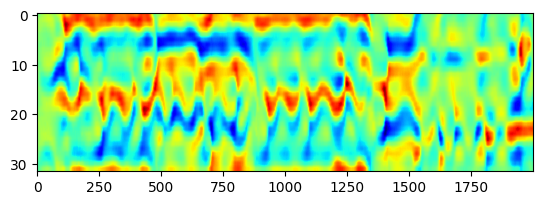

In [88]:
#Difference between noicy data and real data
plt.imshow(
    differ_3 - differ_4,
    cmap=plt.get_cmap("jet"),
    aspect=20,
)

## Using Mackey-Glass time series(data) instead of my kuramoto data (THIRD TASK)

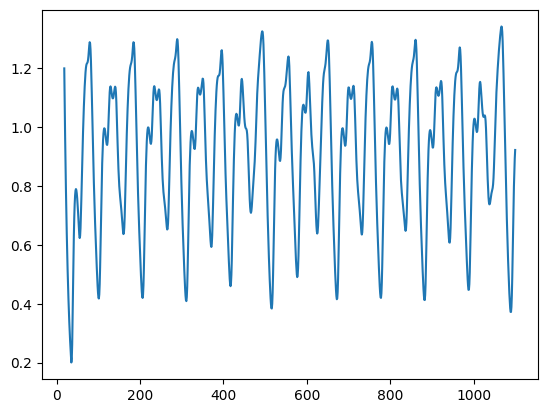

In [129]:
import math
import matplotlib.pyplot as plt
import csv

t_min = 18
t_max = 1100

beta = 0.2
gamma = 0.1
tao = 17
n = 10


x = []
for i in range(1, t_min) :
    x.append(0.0)
x.append(1.2)

for t in range(t_min, t_max):
    h = x[t-1] + (beta * x[t-tao-1] / (1 + math.pow(x[t-tao-1], n))) - (gamma * x[t-1])
    h = float("{:0.4f}".format(h))
    x.append(h)  
    

plt.plot(range(t_min, t_max+1), x[t_min-1:t_max])


data = []
x = x[t_min-1:t_max]

for t in range(3, len(x)):
    d = []
    d.append(x[t-3])
    d.append(x[t-2])
    d.append(x[t-1])
    d.append(x[t])
    data.append(d)

with open('data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data)

In [130]:
data = np.array(data)

In [140]:
data.size

4320

In [141]:
reshaped_data = data.reshape(32, 4320//32)

In [170]:
# I will change reservoir params because my data size is now other(much more smaller)
new_res_params = {
    "radius": 0.1,                    # Radius of the reservoir
    "degree": 3,                      # Degree of the reservoir
    "sigma": 0.5,                     # Spread parameter
    "train_length": 135,            # Length of training data
    "N": int(np.floor(approx_res_size / model_params["N"]) * model_params["N"]),  # Adjusted size of reservoir
    "num_inputs": model_params["N"],  # Number of inputs to the reservoir
    "predict_length": 135,           # Length of prediction data
    "beta": 0.0001                    # Regularization parameter
}

In [171]:
x_new, Wout_new, A_new, Win_new = train_reservoir(
    res_params, reshaped_data[:, shift_k : shift_k + res_params["train_length"]]
)

In [172]:
# Prediction
prediction_new, _ = predict(A_new, Win_new, res_params, x_new, Wout_new)

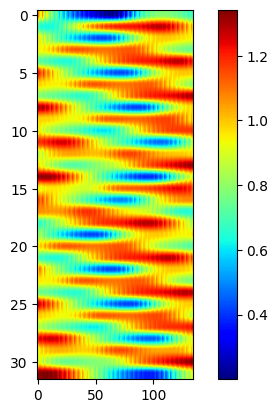

In [176]:
plt.imshow(
    reshaped_data[:, -res_params["predict_length"] :], cmap=plt.get_cmap("jet"), aspect=10
)
plt.colorbar()

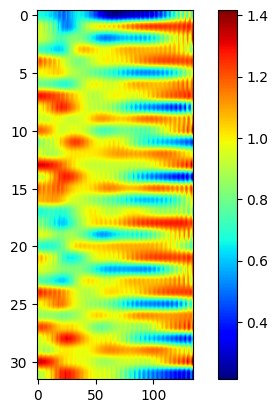

In [177]:
plt.imshow(prediction_new, cmap=plt.get_cmap("jet"), aspect=10)
plt.colorbar()

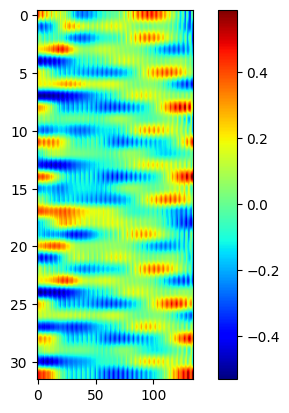

In [178]:
#Difference
plt.imshow(
    reshaped_data[:, -res_params["predict_length"] :] - prediction_new,
    cmap=plt.get_cmap("jet"),
    aspect=10,
)
plt.colorbar()